(This could be our final notebook for project submission)

In [2]:
import pandas as pd
import os
from config import *
import json
import glob

### Overview of the data (Thomson Reuters News Articles)

This dataset contains articles from 1996 - 2020.
The total number of English articles that talk about the US: 

In [2]:
# Notebook that generates count is called 'generate_all_us_article_count.ipynb'
# Output stored at "All_US_Article_Count.csv"
df = pd.read_csv(os.path.join(TEMP_PATH, 'All_US_Article_Count.csv'), index_col=[0])
df.Count.sum()

19878246

In [3]:
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

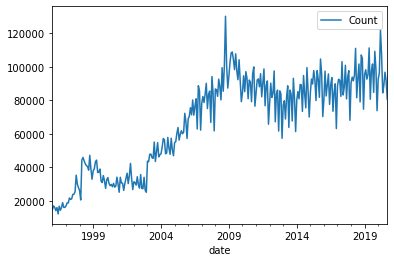

In [4]:
df.plot()

This plot depicts the article count over the years (English, about the US only)

### 1. Filtering the articles based on our themes

We looked into the dataset specifications and identified some tags that were helpful to start our analysis (instead of using a bag of words, word2vec similarity approach, and identifying articles related to "Inflation", "GDP" and "Volatility"

Specifically, Reuters classifies articles based on whether they talk about certain economic indicators. We were able to find exact classifications for Inflation and GDP, but not for Volatility.

#### 1.a. Inflation

We filter the articles each year for the topic 'N2:INFL'. This part of the processing was executed on the grid with the output being a json files for each year that contain the filename and the article ids that talk about inflation.

The processing was undertaken in `Inflation_filter.py`

Command run: `sge_run --grid_submit=batch --grid_mem=25G --grid_SGE_TASK_ID=1-25 ./Inflation_filter.py`


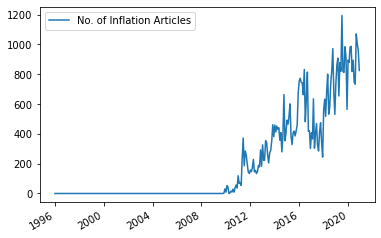

In [5]:
# Looking at the number of articles over the years
infl_files = glob.glob(TEMP_PATH + '/Inflation/*.json')

article_count = dict()
for infl_file in infl_files:
    f = open(infl_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of Inflation Articles'}, inplace=True)

article_count.plot()

In [6]:
article_count['No. of Inflation Articles'].sum()

60096

#### 1.b. GDP

We filter the articles each year for the topic 'N2:GDP'. This part of the processing was also executed on the grid as above.

The processing was undertaken in `GDP_filter.py`

Command run: `sge_run --grid_submit=batch --grid_mem=25G --grid_SGE_TASK_ID=1-25 ./GDP_filter.py`

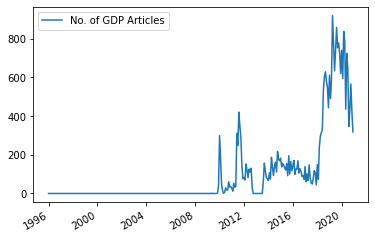

In [7]:
# Looking at the number of articles over the years
gdp_files = glob.glob(TEMP_PATH + '/GDP/*.json')

article_count = dict()
for gdp_file in gdp_files:
    f = open(gdp_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of GDP Articles'}, inplace=True)

article_count.plot()

In [8]:
article_count['No. of GDP Articles'].sum()

30082

From the graphs of inflation and GDP we can see that the Thomson Reuters filters began to be used in 2009, which means that if we use this approach we would be missing all the articles before this date. For this reason we decided to try to construct our own filter using word similarity of our themes of interest using Word2Vec. Also, since there was no tag corrsponding to volatility we still needed to create a custom filter to be able to extract the articles that mention that theme.

### 2. Word2Vec Similarity Models

Since regimes take some time to shift from one regime to another and our smallest level of analysis is monthly, we thought that using the most similar words within a year would be enough to capture the relevant articles. We decided to construct our word similarity model for each year in our data set (1996-2020), with the output being the 10 most similar words for each of the themes.

#### 2.1 Inflation based on Word2Vec similarity model words filtering

In [12]:
words = pd.read_csv(TEMP_PATH + '/inflation_words.csv', index_col=0)

words.index += 1
words.T

,1,2,3,4,5,6,7,8,9,10
1996,inflationary,cpi,economy,unemployment,gdp,ppi,wages,pressures,wage,economic
1997,inflationary,wage,unemployment,cpi,economy,wages,productivity,joblessness,ppi,pressures
1998,inflationary,unemployment,cpi,wage,productivity,wages,incomes,economy,deflation,gdp
1999,inflationary,cpi,ppi,wage,economy,deflation,deflationary,productivity,gdp,overheating
2000,inflationary,cpi,ppi,wage,productivity,deflation,gdp,economy,pressures,tame
2001,inflationary,cpi,ecb,gdp,deflation,economy,unemployment,rpix,productivity,growth
2002,inflationary,gdp,tame,economy,ecb,rpix,cpi,disinflation,joblessness,deflation
2003,deflation,gdp,disinflation,cpi,policymakers,ecb,economy,inflationary,payrolls,fed
2004,cpi,inflationary,gdp,payrolls,fed,bernanke,benign,greenspan,transitory,deflation
2005,inflationary,cpi,fed,gdp,ppi,payrolls,easing,tame,greenspan,vigilance


The processing was undertaken in `Inflation_filter_v2.py`

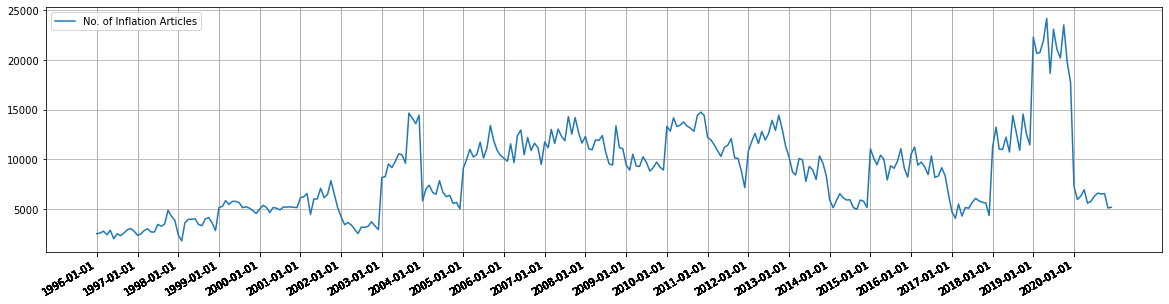

In [68]:
# Looking at the number of articles over the years
infl_files = glob.glob(TEMP_PATH + '/Inflation/Inflation_Articles_v2_*.json')

article_count = dict()
for infl_file in infl_files:
    f = open(infl_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of Inflation Articles'}, inplace=True)

article_count.plot(grid=True, figsize=(20,5), xticks=[pd.to_datetime(str(y), format='%Y') for y in article_count.index.year])

In [69]:
article_count['No. of Inflation Articles'].sum()

2596767

In [59]:
article_count.to_csv('Summary Stat Tables/Inflation_Article_Count.csv')

#### 2.2 GDP Based

The processing was undertaken in `GDP_filter_v2.py`

In [14]:
words = pd.read_csv(TEMP_PATH + '/gdp_words.csv', index_col=0)

words.index += 1
words.T

,1,2,3,4,5,6,7,8,9,10
1996,cpi,annualised,inflation,economists,ppi,gross,economy,annualized,unemployment,figure
1997,gross,deficit,indx,cpi,drbls,clms,inflation,consumption,unemployment,xhms
1998,cpi,deficit,inflation,economy,employment,eci,consumption,payroll,ppi,unemployment
1999,cpi,ppi,employment,inflation,joblessness,payrolls,unemployment,revision,economy,deficit
2000,cpi,ppi,payrolls,pmi,employment,inflation,economists,unrevised,capex,revised
2001,inflation,cpi,contraction,consumption,payrolls,reading,revised,employment,gross,figure
2002,annualised,inflation,cpi,consumption,payrolls,productivity,economy,gross,employment,reading
2003,inflation,unrevised,economy,fdi,payrolls,oecd,eurozone,insee,contraction,jobless
2004,inflation,payrolls,cpi,durable,ppi,pmi,unrevised,output,jobs,payroll
2005,cpi,ppi,inflation,payrolls,factory,productivity,durable,oecd,jobless,output


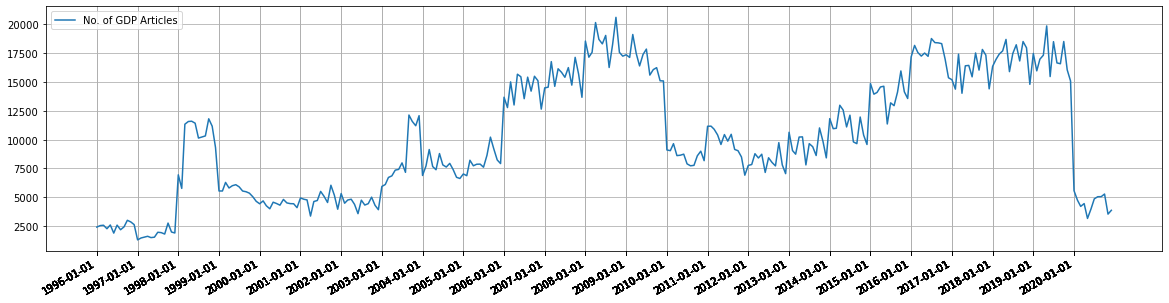

In [60]:
# Looking at the number of articles over the years
infl_files = glob.glob(TEMP_PATH + '/GDP/GDP_Articles_v2_*.json')

article_count = dict()
for infl_file in infl_files:
    f = open(infl_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of GDP Articles'}, inplace=True)

article_count.plot(grid=True, figsize=(20,5), xticks=[pd.to_datetime(str(y), format='%Y') for y in article_count.index.year])

In [61]:
article_count['No. of GDP Articles'].sum()

3072594

In [62]:
article_count.to_csv('Summary Stat Tables/GDP_Article_Count.csv')

#### 2.3 Volatility Based

The processing was undertaken in `Volatility_filter_v2.py`

In [15]:
words = pd.read_csv(TEMP_PATH + '/volatility_words.csv', index_col=0)

words.index += 1
words.T

,1,2,3,4,5,6,7,8,9,10
1996,volatilities,correction,backwardation,correlation,trend,swings,upside,steepening,downside,fluctuations
1997,volatilities,vols,options,reversal,reversals,nervousness,correction,selloff,curve,inversion
1998,volatilities,vols,options,implied,oex,reversals,anxiety,reversal,activity,nervousness
1999,volatilities,vols,volatilies,implied,options,skew,reversals,flattening,midmarket,weakness
2000,vols,volatilities,gyrations,correction,pullback,swings,inversion,weakness,flattening,bullishness
2001,volatilities,vols,gyrations,underperformance,fluctuations,uncertainty,implied,spike,bullishness,choppier
2002,fluctuations,uncertainty,nervousness,weakness,swings,volatile,fluctuation,movements,strength,bullishness
2003,fluctuations,weakness,volatile,movements,uncertainty,fluctuation,variability,declines,spikes,exposure
2004,movements,fluctuations,fluctuation,adjustment,exposure,bearishness,swings,risk,variability,weakness
2005,fluctuations,sensitivity,exposure,volatile,risk,variability,movements,uncertainty,weakness,bullishness


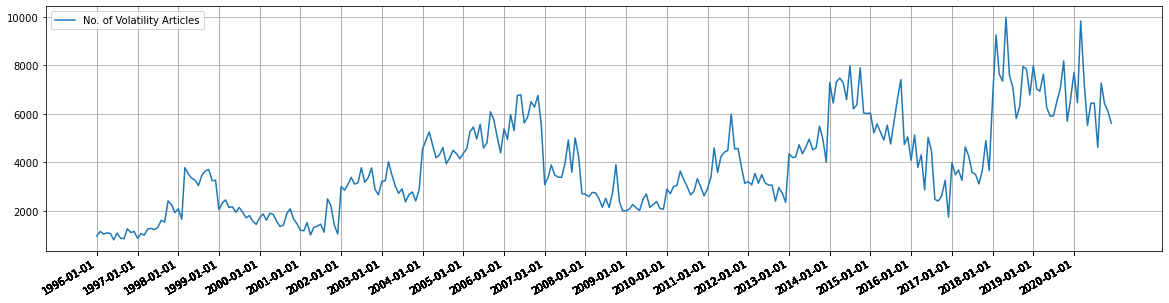

In [63]:
# Looking at the number of articles over the years
infl_files = glob.glob(TEMP_PATH + '/Volatility/Volatility_Articles_v2_*.json')

article_count = dict()
for infl_file in infl_files:
    f = open(infl_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of Volatility Articles'}, inplace=True)

article_count.plot(grid=True, figsize=(20,5), xticks=[pd.to_datetime(str(y), format='%Y') for y in article_count.index.year])

In [64]:
article_count['No. of Volatility Articles'].sum()

1160075

In [66]:
article_count.to_csv('Summary Stat Tables/Volatility_Article_Count.csv')

### 3. Sequential Topic Modeling

To identify regimes within each of our themes, our next task was to use the filtered articles to identify coherent topics that would roughly translate to a "state" of the state variable (theme) - inflation/ GDP/ Volatility.
To do this, we thought it would be best to use a dynamic LDA model, that would optimize the topics to be coherent across the specified time slices.

In our model, this ideally translates to having time slices for each month in our sample (300 months).
The code for these models is at `{THEME}_LDA_monthly.py`.

#### Pre-processing the texts

To run a sequential LDA model, we needed a Bag of words representation of each of the articles in our three filtered corpora. The first step was to pre-process the text for each article: tokenize, removing non-alpha characters, stop words, converting to lower case.


Next, we restricted the articles to the effective vocabulary - this is a list of words that exclude the top 50 most frequently occurring words in the sample, and words that appear only once. This step takes time, and was parallelized for each year on the grid. 

Script used: `{THEME}_tokenizing.py`

Command run to parallelize on the grid: `sge_run --grid_submit=batch --grid_mem=25G --grid_SGE_TASK_ID=1-25 {THEME}_filter.py`

After obtaining the tokenized articles within the effective articles, we create Bag of Words. We used `gensim`'s methods to first create a dictionary that stores  

However, we realized that the processing time was way too high, and it was extremely computationally intensive.

#### Identifying more stop words